## ⭐ Setup
You must run all codes under this category.

### ✅ Packages Handling

In [ ]:
# @title  { display-mode: "form" }
# @markdown Built-in packages.

import os
import shutil
import glob
import tarfile
import time

In [ ]:
# @title  { display-mode: "form" }
# @markdown Useful packages.

import yaml
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
try:
  from google.colab import files
  from google.colab import userdata
except:
  pass

In [ ]:
# @title  { display-mode: "form" }
# @markdown Other required packages.

%pip install wget -qq
import wget
%pip install starfile -qq
import starfile

  Preparing metadata (setup.py) ... done


In [ ]:
# @title  { display-mode: "form" }
# @markdown Cryo-em packages.

%pip install mrcfile -qq
import mrcfile

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 1.5 MB/s eta 0:00:00


### ✅ Function

In [ ]:
# @title  { display-mode: "form" }
# @markdown Operating system

def get_basename(path):
  return os.path.basename(path)

def get_basename_with_uid_removed(path):
  return os.path.basename(path).split(sep='_', maxsplit=1)[-1]

def change_root(path, root):
  basename = os.path.basename(path)
  return os.path.join(root, basename)

def change_root_func(root):
  def func(path):
    basename = os.path.basename(path)
    return os.path.join(root, basename)
  return func

def change_root_with_particle_id_remain(root):
  def func(path):
    particle_id = path.split('@')[0]
    basename = os.path.basename(path)
    return os.path.join(particle_id+'@'+root, basename)
  return func

In [ ]:
# @title  { display-mode: "form" }
# @markdown Data preparation

def download_extract_empiar(save_to, empiar_id, url):
  """
  Download the EMPIAR-XXXXX.tar.g to `save_to`,
  where the XXXXX is the empiar_id.
  Extract the EMPIAR-XXXXX.tar.gz after downloading.
  """

  empiar_dir = os.path.join(save_to, f"EMPIAR-{empiar_id}")

  if not os.path.isdir(empiar_dir):
    downloaded_path = os.path.join(save_to, f"{empiar_id}")
    try:
      os.mkdir(downloaded_path)
      if not os.path.exists(f"{TMP_DIR}/{empiar_id}.tar.gz"):
        print(f"Downloading {empiar_id}.tar.gz.")
        wget.download(f"{url}/{empiar_id}.tar.gz", f"{TMP_DIR}/{empiar_id}.tar.gz")
      # extract EMPIAR-XXXXX.tar.gz, same utility as
      with tarfile.open(f"{TMP_DIR}/{empiar_id}.tar.gz") as tar:
        print(f"Extracting {empiar_id}.tar.gz.")
        tar.extractall(path=save_to, filter='data')
    except FileExistsError:
      print(f"{empiar_id} exist but not rename to EMPIAR-{empiar_id}.")
    finally:
      os.rename(downloaded_path, empiar_dir)

  return empiar_dir

def get_particles_by_starfile(star_file, micrograph_dir, particle_dir=None):
    particle_selected = starfile.read(star_file)
    try:
      optics = particle_selected['optics']
      particles = particle_selected['particles']
    except:
      particles = particle_selected
    rlnMicrographName = particles.pop('rlnMicrographName')
    rlnImageName = particles.pop('rlnImageName')
    columns = particles.columns
    try:
        particles["rlnMicrographName"] = rlnMicrographName.apply(os.path.basename)
        particles["MicrographName"] = particles['MicrographName'].apply(lambda x: x.split(sep='_', maxsplit=1)[-1])
    except:
        pass
    try:
        particles["ImageName"] = rlnImageName.apply(os.path.basename)
    except:
        pass
    micrograph_names = sorted(particles["MicrographName"].unique())
    micrograph_path = []
    particle_paths = []
    coordinate = []
    for micrograph_name in micrograph_names:
        particle = particles[particles["MicrographName"]==micrograph_name]
        micrograph_path.append(os.path.join(micrograph_dir, particle["MicrographName"].iloc[0]))
        particle_paths.append(os.path.join(particle_dir, particle["ImageName"].iloc[0]))
        coordinate.append(particle[columns])
        coordinate[-1].reset_index()
    return (
        optics,
        pd.DataFrame({
            "Micrograph": micrograph_path,
            "Particle": particle_paths,
            "Coordinate": coordinate,
        },
        index=micrograph_names)
    )

### ✅ Directory Settings

In [ ]:
# @title  { display-mode: "form" }
# @markdown Directory parameters.

DATA_DIR = "/content/dataset" # @param {type:"string"}
RESULT_DIR = "/content/drive/MyDrive/research_xs" # @param {type:"string"}
TMP_DIR = "/content/tmp" # @param {type:"string"}
SOFTWARE_DIR = "/content/software" # @param {type:"string"}
WORK_DIR = os.getcwd()

In [ ]:
# @title  { display-mode: "form" }
# @markdown Run this block if using folder📁 in Google Drive as **`RESULT_DIR`**.

try:
  from google.colab import drive
  drive.mount('/content/drive')
except:
  pass

Mounted at /content/drive


In [ ]:
# @title  { display-mode: "form" }
# @markdown Run this block for remove the **`sample_data`** folder📁 in content

if os.path.isdir("/content/sample_data"):
  !rm -r /content/sample_data
# from shutil import rmtree
#
# rmtree(f"/content/sample_data")

In [ ]:
# @title  { display-mode: "form" }
# @markdown Run this block for checking the existence of the directories

if not os.path.isdir(DATA_DIR):
  os.mkdir(DATA_DIR)

if not os.path.isdir(RESULT_DIR):
  os.mkdir(RESULT_DIR)

if not os.path.isdir(TMP_DIR):
  os.mkdir(TMP_DIR)

if not os.path.isdir(SOFTWARE_DIR):
  os.mkdir(SOFTWARE_DIR)

### ✅ EMPIAR Data Setting

In [ ]:
# @title  { vertical-output: true, display-mode: "form" }
EMPIAR_ID = 10081 # @param {type:"integer"}

In [ ]:
EMPIAR_DIR = os.path.join(DATA_DIR, f"EMPIAR-{EMPIAR_ID}")
EMPIAR_ID, DATA_DIR, RESULT_DIR

(10081, '/content/dataset', '/content/drive/MyDrive/research_xs')

In [ ]:
# @title  { vertical-output: true, display-mode: "form" }
# @markdown Data Downloading.

url = "https://calla.rnet.missouri.edu/cryoppp" # @param ["https://calla.rnet.missouri.edu/cryoppp"]
use_diretory = f"/content/drive/MyDrive/research_xs/dataset/{EMPIAR_ID}" # @param {type:"string"}

if os.path.exists(use_diretory):
  start_time = time.time()
  !mkdir {DATA_DIR}/{EMPIAR_ID}
  !cp -r {use_diretory}/* {DATA_DIR}/{EMPIAR_ID}
  os.rename(os.path.join(DATA_DIR, f"{EMPIAR_ID}"),
            os.path.join(DATA_DIR, f"EMPIAR-{EMPIAR_ID}"))
  EMPIAR_DIR = os.path.join(DATA_DIR, f"EMPIAR-{EMPIAR_ID}")
  end_time = time.time()
  print("Time used:", end_time-start_time)
else:
  start_time = time.time()
  EMPIAR_DIR = download_extract_empiar(DATA_DIR, EMPIAR_ID, url=url)
  end_time = time.time()
  print("Time used:", end_time-start_time)

Time used: 1346.6325590610504


In [ ]:
!mkdir {RESULT_DIR}/dataset/
!mkdir {RESULT_DIR}/dataset/{EMPIAR_ID}

mkdir: cannot create directory ‘/content/drive/MyDrive/research_xs/dataset/’: File exists


In [ ]:
# @title  { vertical-output: true, display-mode: "form" }
# @markdown Assigning processed data directory.
PROCESSED_DIR = f"{EMPIAR_DIR}/processed"

if not os.path.isdir(PROCESSED_DIR):
  os.mkdir(PROCESSED_DIR)

print(f"PROCESSED_DIR: {PROCESSED_DIR}")

PROCESSED_DIR: /content/dataset/EMPIAR-10081/processed


## ⏭ Software Installation
You can choose the software you want according to your needs.

#### 🟪 Topaz Installation

In [ ]:
# @title  { display-mode: "form" }

INSTALL = True # @param {type:"boolean"}

if INSTALL:
  %pip install topaz-em -qq

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.2/48.2 MB 902.4 kB/s eta 0:00:00


#### 🟪 CryoSPARC Installation

In [ ]:
# @title  { display-mode: "form" }

INSTALL = True # @param {type:"boolean"}

In [ ]:
# @title  { display-mode: "form" }
# @markdown Download and extract CryoSPARC.

if INSTALL:
  try:
    LICENSE_ID = 'de83cc14-927c-11ed-8bff-53442f46f4ed'
  except:
    pass

  os.environ['LICENSE_ID'] = LICENSE_ID

  %cd {SOFTWARE_DIR}
  %mkdir cryosparc
  %cd cryosparc
  if not os.path.isdir("cryosparc_master"):
    if not os.path.exists("cryosparc_master.tar.gz"):
      !curl -L https://get.cryosparc.com/download/master-latest/$LICENSE_ID -o cryosparc_master.tar.gz
    !tar -xf cryosparc_master.tar.gz cryosparc_master
    !rm /content/software/cryosparc/cryosparc_master.tar.gz
  if not os.path.isdir("cryosparc_worker"):
    if not os.path.exists("cryosparc_worker.tar.gz"):
      !curl -L https://get.cryosparc.com/download/worker-latest/$LICENSE_ID -o cryosparc_worker.tar.gz
    !tar -xf cryosparc_worker.tar.gz cryosparc_worker
    !rm /content/software/cryosparc/cryosparc_worker.tar.gz

/content/software
/content/software/cryosparc
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:--  0:00:03 --:--:--     0
100  626M  100  626M    0     0  16.3M      0  0:00:38  0:00:38 --:--:-- 19.9M
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 3987M  100 3987M    0     0  15.4M      0  0:04:17  0:04:17 --:--:-- 15.6M


In [ ]:
# @title  { display-mode: "form" }
# @markdown Install CryoSPARC.

if INSTALL:
  %cd cryosparc_master
  !apt-get install iputils-ping -y
  %mkdir /content/software/cryosparc/cryosparc_cache
  os.environ['LICENSE_ID'] = LICENSE_ID
  # %env LICENSE_ID=
  %env CRYOSPARC_FORCE_USER=true
  %env USER=phonchi
  !./install.sh    --standalone \
          --license $LICENSE_ID \
          --worker_path /content/software/cryosparc/cryosparc_worker \
          --ssdpath /content/software/cryosparc/cryosparc_cache \
          --initial_email "steve2003121@gmail.com" \
          --initial_password "CryoSPARC00" \
          --initial_username "phonchi" \
          --initial_firstname "Szu Chi" \
          --initial_lastname "Chung" \
          --port 61000
  %cd {WORK_DIR}
  #         --cudapath /usr/local/cuda \

/content/software/cryosparc/cryosparc_master
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  iputils-ping
0 upgraded, 1 newly installed, 0 to remove and 49 not upgraded.
Need to get 42.9 kB of archives.
After this operation, 116 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/main amd64 iputils-ping amd64 3:20211215-1 [42.9 kB]
Fetched 42.9 kB in 1s (46.4 kB/s)
Selecting previously unselected package iputils-ping.
(Reading database ... 123597 files and directories currently installed.)
Preparing to unpack .../iputils-ping_3%3a20211215-1_amd64.deb ...
Unpacking iputils-ping (3:20211215-1) ...
Setting up iputils-ping (3:20211215-1) ...
Processing triggers for man-db (2.10.2-1) ...
env: CRYOSPARC_FORCE_USER=true
env: USER=phonchi

************ CRYOSPARC SYSTEM: STANDALONE INSTALLER **************

You are the root user. Are you sure you want to install as

In [ ]:
# @title  { display-mode: "form" }
# @markdown Install pyngrok.

if INSTALL:
  %pip install pyngrok -qq

#### 🟪 Pyem Installation

In [ ]:
# @title  { display-mode: "form" }

INSTALL = True # @param {type:"boolean"}

if INSTALL:
  %cd {SOFTWARE_DIR}
  !pip install pyFFTW
  !pip install healpy
  !pip install pathos
  !git clone https://github.com/asarnow/pyem.git
  %cd pyem
  !pip install --no-dependencies -e .
  %cd {WORK_DIR}

/content/software
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 31.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 54.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.1/82.1 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 13.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.8/56.8 kB 5.4 MB/s eta 0:00:00
Cloning into 'pyem'...
remote: Enumerating objects: 3963, done.
remote: Counting objects: 100% (1389/1389), done.
remote: Compressing objects: 100% (236/236), done.
remote: Total 3963 (delta 1211), reused 1296 (delta 1151), pack-reused 2574 (from 1)
Receiving objects: 100% (3963/3963), 715.82 KiB | 3.31 MiB/s, done.
Resolving deltas: 100% (2774/2774), done.
/content/software/pyem
Obtaining file:///content/software/pyem
  Preparing metadata (setup.py) ... done
  Running setup.py develop for pyem
/content


#### 🟪 Relion Installation

In [ ]:
# @title  { display-mode: "form" }
INSTALL = True # @param {type:"boolean"}

if INSTALL:
  %cd {SOFTWARE_DIR}
  !sudo apt install libfftw3-dev
  !git clone https://github.com/3dem/relion.git
  %cd relion
  !git checkout master # or ver4.0
  %mkdir build
  %cd build
  !cmake ..
  !make -j8
  !make install
  %cd {WORK_DIR}

## ⏭ Data Preparation

### 🟪 Micrograph preprocessing (by topaz).

In [ ]:
# @title  { vertical-output: true, display-mode: "form" }
# @markdown Preprocess the micrograph using topaz.

topaz_preprocessing = True # @param {type:"boolean"}
save_preprocessing = True # @param {type:"boolean"}

if not os.path.isdir(os.path.join(PROCESSED_DIR, "micrographs")):
  if topaz_preprocessing:
    !topaz preprocess -v -o {PROCESSED_DIR}/micrographs/ {EMPIAR_DIR}/micrographs/*.mrc
    if save_preprocessing:
      !mkdir {RESULT_DIR}/dataset/{EMPIAR_ID}/processed_micrographs
      !cp -r {PROCESSED_DIR}/micrographs/* {RESULT_DIR}/dataset/{EMPIAR_ID}/processed_micrographs/
  else:
    start_time = time.time()
    !mkdir {PROCESSED_DIR}/micrographs
    !cp -r {RESULT_DIR}/dataset/{EMPIAR_ID}/processed_micrographs/* {PROCESSED_DIR}/micrographs/
    end_time = time.time()
    print("Time used:", end_time-start_time)
    # !unzip -xf {RESULT_DIR}/processed_micrographs.zip {PROCESSED_DIR}/micrographs

Traceback (most recent call last):
  File "/usr/lib/python3.10/multiprocessing/pool.py", line 856, in next
    item = self._items.popleft()
IndexError: pop from an empty deque

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/bin/topaz", line 8, in <module>
    sys.exit(main())
  File "/usr/local/lib/python3.10/dist-packages/topaz/main.py", line 148, in main
    args.func(args)
  File "/usr/local/lib/python3.10/dist-packages/topaz/commands/normalize.py", line 129, in main
    for name in pool.imap_unordered(process, paths):
  File "/usr/lib/python3.10/multiprocessing/pool.py", line 861, in next
    self._cond.wait(timeout)
  File "/usr/lib/python3.10/threading.py", line 320, in wait
    waiter.acquire()
KeyboardInterrupt
Process ForkPoolWorker-5:
Traceback (most recent call last):
  File "/usr/lib/python3.10/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/usr/lib/python3.10/multiproce

### 🟪 Handling `selected.star` and `particles.txt` (by topaz).

In [ ]:
# @title  { display-mode: "form" }
# @markdown Try to move those files from **`RESULT DIR`** 📁 to **`PROCESSED DIR`** 📁.

try:
  shutil.copy(f"{RESULT_DIR}/dataset/{EMPIAR_ID}/selected.star", PROCESSED_DIR)
  selected_star_exist = True
except:
  print(f"No selected.star found in {RESULT_DIR}/dataset/{EMPIAR_ID}/")
  selected_star_exist = False

No selected.star found in /content/drive/MyDrive/research_xs/dataset/10017/


In [ ]:
# @markdown Generate selected particle starfile that is suitable for topaz (**`selected.star`**) if it is not in **`RESULT DIR`** 📁. { display-mode: "form" }

# @markdown Use **`selected.star`** from **`RESULT DIR`** 📁.
use_result = False # @param {type:"boolean"}
if use_result:
  try:
    shutil.copy(f"{RESULT_DIR}/dataset/{EMPIAR_ID}/selected.star", f"{PROCESSED_DIR}")
  except:
    pass

# @markdown Force to generate a new **`selected.star`**.
FORCE = True # @param {type:"boolean"}
if FORCE or not os.path.exists(f"{PROCESSED_DIR}/selected.star"):
  remove_root = True # @param {type:"boolean"}
  SAVE = True # @param {type:"boolean"}

  df = starfile.read(f"{EMPIAR_DIR}/ground_truth/empiar-{EMPIAR_ID}_particles_selected.star")
  df_optics, df_particles = df['optics'].copy(), df['particles'].copy()
  if remove_root:
    df_particles['rlnImageName'] = df_particles['rlnImageName'].apply(get_basename)
    df_particles['rlnMicrographName'] = df_particles['rlnMicrographName'].apply(get_basename_with_uid_removed)
  else:
    df_particles['rlnImageName'] = df_particles['rlnImageName'].apply(change_root_with_particle_id_remain(f"{EMPIAR_DIR}/particles_stack"))
    df_particles['rlnMicrographName'] = df_particles['rlnMicrographName'].apply(change_root_func(f"{PROCESSED_DIR}/micrographs"))

  starfile.write(df_particles, f"{PROCESSED_DIR}/selected.star")
  if SAVE:
    shutil.copy(f"{PROCESSED_DIR}/dataset/{EMPIAR_ID}/selected.star", RESULT_DIR)

In [ ]:
# Remove root!
df_particles

rlnImageName           rlnMicrographName  \
0      HCN1apo_0183_2xaligned_particles.mrc  HCN1apo_0183_2xaligned.mrc   
1      HCN1apo_0183_2xaligned_particles.mrc  HCN1apo_0183_2xaligned.mrc   
2      HCN1apo_0183_2xaligned_particles.mrc  HCN1apo_0183_2xaligned.mrc   
3      HCN1apo_0183_2xaligned_particles.mrc  HCN1apo_0183_2xaligned.mrc   
4      HCN1apo_0183_2xaligned_particles.mrc  HCN1apo_0183_2xaligned.mrc   
...                                     ...                         ...   
39347  HCN1apo_0686_2xaligned_particles.mrc  HCN1apo_0686_2xaligned.mrc   
39348  HCN1apo_0686_2xaligned_particles.mrc  HCN1apo_0686_2xaligned.mrc   
39349  HCN1apo_0686_2xaligned_particles.mrc  HCN1apo_0686_2xaligned.mrc   
39350  HCN1apo_0686_2xaligned_particles.mrc  HCN1apo_0686_2xaligned.mrc   
39351  HCN1apo_0686_2xaligned_particles.mrc  HCN1apo_0686_2xaligned.mrc   

       rlnCoordinateX  rlnCoordinateY  rlnAnglePsi  rlnOriginXAngst  \
0                2041             384   349.897949        -0.422500   
1                 985            2821   103.775505         1.267500   
2                2258            2066    57.857143        -0.422500   
3                1529             620   276.428558        -1.267500   
4                3416             256   283.775482        -0.422500   
...               ...             ...          ...              ...   
39347            1861             134    26.632650        -3.802500   
39348             966            2712   302.142822        12.252500   
39349            2316            2847   173.571426        13.942500   
39350            2047            1682   112.959175       -11.407499   
39351             908            3448    26.632650        -8.027500   

       rlnOriginYAngst   rlnDefocusU   rlnDefocusV  rlnDefocusAngle  \
0            -1.267500  18693.681641  17792.365234       -75.985649   
1            -2.112500  18627.705078  17726.388672       -75.985649   
2             2.112500  18799.509766  17898.193359       -75.985649   
3            -2.112500  18722.833984  17821.517578       -75.985649   
4            -0.422500  18868.507812  17967.191406       -75.985649   
...                ...           ...           ...              ...   
39347        14.787499  21976.574219  20989.371094       -75.429733   
39348        -9.717500  22019.349609  21032.146484       -75.429733   
39349         8.027500  21821.414062  20834.210938       -75.429733   
39350       -14.787499  21797.146484  20809.943359       -75.429733   
39351        12.252500  21968.212891  20981.009766       -75.429733   

       rlnPhaseShift  rlnCtfBfactor  rlnOpticsGroup  rlnClassNumber  
0                0.0            0.0               1              38  
1                0.0            0.0               1              38  
2                0.0            0.0               1              38  
3                0.0            0.0               1              38  
4                0.0            0.0               1              38  
...              ...            ...             ...             ...  
39347            0.0            0.0               1              20  
39348            0.0            0.0               1              37  
39349            0.0            0.0               1              48  
39350            0.0            0.0               1              46  
39351            0.0            0.0               1              49  

[39352 rows x 14 columns]

In [ ]:
# @markdown ⛔ Problem (Solved by running this cell.)

# @markdown If using ` --invert-y`, `--image-ext` need to be set to `mrc`,
# @markdown and `coords = coords.clone()` in
# @markdown "/usr/local/lib/python3.10/dist-packages/topaz/utils/conversions.py"
# @markdown need to be change to `coords = coords.copy()`
%%writefile /usr/local/lib/python3.10/dist-packages/topaz/utils/conversions.py

from __future__ import print_function,division

import topaz.utils.star as star

import numpy as np
import pandas as pd

def mirror_y_axis(coords, n):
    coords = coords.copy()
    coords['y_coord'] = n-1-coords['y_coord']
    return coords

def boxes_to_coordinates(boxes, shape=None, invert_y=False, image_name=None):
    if len(boxes) < 1: # boxes are empty, return empty coords table
        columns = ['x_coord', 'y_coord']
        if image_name is not None:
            columns.append('image_name')
        coords = pd.DataFrame(columns=columns)
        return coords

    ## first 2 columns are x and y coordinates of lower left box corners
    ## next 2 columns are width and height

    ## requires knowing image size to invert y-axis (shape parameter)
    ## to conform with origin in upper-left rather than lower-left
    ## apparently, EMAN2 only inverts the y-axis for .tiff images
    ## so box files only need to be inverted when working with .tiff
    x_lo = boxes[:,0]
    y_lo = boxes[:,1]
    width = boxes[:,2]
    height = boxes[:,3]
    x_coord = x_lo + width//2
    y_coord = y_lo + height//2

    if invert_y:
        y_coord = (shape[0]-1-y_lo) - height//2

    coords = np.stack([x_coord, y_coord], axis=1)
    if image_name is not None: # in this case, return as table with image_name column
        coords = pd.DataFrame(coords, columns=['x_coord', 'y_coord'])
        coords.insert(0, 'image_name', [image_name]*len(coords))

    return coords

def coordinates_to_boxes(coords, box_width, box_height, shape=None, invert_y=False, tag='manual'):
    entries = []
    x_coords = coords[:,0]
    y_coords = coords[:,1]
    if invert_y:
        y_coords = shape[0]-1-coords[:,1]
    box_width = np.array([box_width]*len(x_coords), dtype=np.int32)
    box_height = np.array([box_height]*len(x_coords), dtype=np.int32)

    # x and y are centers, make lower left corner
    x_coords = x_coords - box_width//2
    y_coords = y_coords - box_height//2

    boxes = np.stack([x_coords, y_coords, box_width, box_height], 1)
    return boxes

def coordinates_to_eman2_json(coords, shape=None, invert_y=False, tag='manual'):
    entries = []
    x_coords = coords[:,0]
    y_coords = coords[:,1]
    if invert_y:
        y_coords = shape[0]-1-coords[:,1]
    for i in range(len(x_coords)):
        entries.append([int(x_coords[i]), int(y_coords[i]), tag])
    return entries


def coordinates_to_star(table, image_ext=''):
    # fix column names to be star format
    d = {'score': star.SCORE_COLUMN_NAME,
            'image_name': 'MicrographName',
            'x_coord': star.X_COLUMN_NAME,
            'y_coord': star.Y_COLUMN_NAME,
            'voltage': star.VOLTAGE,
            'detector_pixel_size': star.DETECTOR_PIXEL_SIZE,
            'magnification': star.MAGNIFICATION,
            'amplitude_contrast': star.AMPLITUDE_CONTRAST,
            }
    table = table.copy()
    for k,v in d.items():
        if k in table.columns:
            table[v] = table[k]
            table = table.drop(k, axis=1)
    # append image extension
    table['MicrographName'] = table['MicrographName'].apply(lambda x: x + image_ext)

    return table


Overwriting /usr/local/lib/python3.10/dist-packages/topaz/utils/conversions.py


In [ ]:
# @title  { display-mode: "form" }
# @markdown Generate particle location txtfile (**`particles.txt`**).

# error: https://github.com/tbepler/topaz/issues/60
# If using ` --invert-y`, set --image-ext with `mrc`,
# and change `coords = coords.clone()` in
# "/usr/local/lib/python3.10/dist-packages/topaz/utils/conversions.py"
# to `coords = coords.copy()`

# @markdown Whether to try using **`particles.txt`** from **`RESULT DIR`**📁.
use_result = False # @param {type:"boolean"}
file_exist = os.path.exists(f"{PROCESSED_DIR}/particles.txt")
if use_result:
  try:
    shutil.copy(f"{RESULT_DIR}/dataset/{EMPIAR_ID}/particles.txt", PROCESSED_DIR)
    file_exist = True
  except:
    print(f"No particles.txt found in {RESULT_DIR}/dataset/{EMPIAR_ID}/")
    file_exist = False

# @markdown Force to generate a new **`particles.txt`**.
FORCE = True # @param {type:"boolean"}
# if FORCE:
#   !rm {RESULT_DIR}/particles.txt
if FORCE or not file_exist:
  # ground_truth_star_path = f"{EMPIAR_DIR}/ground_truth/empiar-{EMPIAR_ID}_particles_selected.star"
  !topaz convert --invert-y --image-ext mrc\
          --imagedir {PROCESSED_DIR}/micrographs/ \
          --from star -o {PROCESSED_DIR}/particles.txt \
           {PROCESSED_DIR}/selected.star
  # {ground_truth_star_path}

  # @markdown Whether to save result to **`RESULT DIR`**📁.
  SAVE = True # @param {type:"boolean"}
  if SAVE:
    shutil.copy(f"{PROCESSED_DIR}/particles.txt", f"{RESULT_DIR}/dataset/{EMPIAR_ID}/")

In [ ]:
shutil.copy(f"{PROCESSED_DIR}/particles.txt", f"{RESULT_DIR}/dataset/{EMPIAR_ID}/")

'/content/drive/MyDrive/research_xs/dataset/10081/particles.txt'

## ⏭ Particles Projection

In [ ]:
# @title  { run: "auto", vertical-output: true, display-mode: "form" }

# @markdown If this option is set to true, the projection of particle (.mrcs) will be created.

# @markdown Files required within the process will be automatically detected and generated.
# @markdown Note that you need to install the corresponding software to guarantee the performance.

project_particles = True # @param {type:"boolean"}
if project_particles:
  if os.path.exists(f"{PROCESSED_DIR}/proj_{EMPIAR_ID}.mrcs"):
    print(f"File exists: {PROCESSED_DIR}/proj_{EMPIAR_ID}.mrcs")
    project_particles = input("Do you sure you want to project particles? y/n\n").lower()=="y"
  elif os.path.exists(f"{PROCESSED_DIR}/proj_{EMPIAR_ID}.star"):
    print(f"File exists: {PROCESSED_DIR}/proj_{EMPIAR_ID}.star")
    project_particles = input("Do you sure you want to project particles? y/n\n").lower()=="y"
  if project_particles:
    print("`project_particles` is set to `True`.")
  else:
    print("`project_particles` is still `False`.")


`project_particles` is set to `True`.


### 🟪 Refining particle (by cryoSPARC).

In [ ]:
EMPIAR_DIR

'/content/dataset/EMPIAR-10081'

In [ ]:
# @title  { vertical-output: true, display-mode: "form" }
# @markdown **`EMPIAR DIR`**📁 should be chosen for project directory.
# @markdown The refinement should be implement in cryoSPARC by:
# @markdown 1. Import particle stack.
# @markdown 2. Build Ab-initio reconstruction.
# @markdown 3. Build non-uniform refinement.

# @markdown The step 1. use `particles_stack` directory and `particles_selected.star` from **`ground_truth`**.
# @markdown Some problems may show up if the root of **`EMPIAR DIR`**📁 is too long.

if project_particles:
  # @markdown Assign `project_name` using the name of the cryoSPARC project.
  project_name = f"empiar-{EMPIAR_ID}" # @param {type:"string"}
  particle_stack_Job = "J1" # @param {type:"string"}
  ab_initio_Job = "J2" # @param {type:"string"}
  refine_Job = "J3" # @param {type:"string"}
  PROJECT_DIR = os.path.join(EMPIAR_DIR, f"CS-{project_name}")
  RUN_REFINEMENT = False

  if os.path.exists(os.path.join(RESULT_DIR, f"refine_{EMPIAR_ID}.star")):
    shutil.copy(os.path.join(RESULT_DIR, f"refine_{EMPIAR_ID}.star"), PROCESSED_DIR)
    print(f"Using refinement result from {RESULT_DIR}")
  elif os.path.exists(os.path.join(PROCESSED_DIR, "refinement_result.star")):
    print("File 'refinement_result.star' already exists.")
  elif os.path.isdir(PROJECT_DIR):
    print(f"Refinement finished.")
    RUN_REFINEMENT = True
  else:
    try:
      from pyngrok import ngrok, conf
      import getpass

      print("Enter your authtoken, which can be copied from https://dashboard.ngrok.com/")
      conf.get_default().auth_token = getpass.getpass()
      # Setup a tunnel to the port 61000
      public_url = ngrok.connect(61000)
      print(public_url)
    except:
      pass
    raise BaseException(
        "Open cryoSPARC for refinement. " +\
        f"Remember to name the project '{project_name}'.\n" +\
        "Rerun this cell after refinement is done."
    )

Refinement finished.


In [ ]:
# @title  { vertical-output: true, display-mode: "form" }
# @markdown Backup entire cryoSPARC porject to **`RESULT DIR`**📁.

backup = True # @param {type:"boolean"}

if project_particles and RUN_REFINEMENT and backup:
  tmp_path = os.path.join(RESULT_DIR, f"CS-{project_name}")
  if os.path.isdir(tmp_path):
    print(f"File exists: '{tmp_path}'")
  else:
    #os.mkdir(tmp_path)
    print(f"Copy 'CS-{project_name}' from '{EMPIAR_DIR}' to '{RESULT_DIR}'.")
    shutil.copytree(PROJECT_DIR, tmp_path)

Copy 'CS-empiar-10081' from '/content/dataset/EMPIAR-10081' to '/content/drive/MyDrive/research_xs'.


### 🟪 Convert refinement result from cryoSPARC form to relion form (by pyem).

In [ ]:
# @title  { vertical-output: true, display-mode: "form" }

if project_particles:
  if os.path.exists(f"{PROCESSED_DIR}/refinement_result.star"):
    print("File 'refinement_result.star' already exists.")
  elif not os.path.isdir(f"{PROJECT_DIR}"):
    raise FileNotFoundError(f"No refinement result inside '{PROJECT_DIR}'.")
  else:
    with open(f"{PROJECT_DIR}/{refine_Job}/{refine_Job}_particles.csg", 'r') as f:
      refine_particles = yaml.safe_load(f)
    refinement_ctf = refine_particles['results']['ctf']['metafile'][1:]
    refinement_blob = refine_particles['results']['blob']['metafile'][1:]
    # csparc2star --inverty?
    !csparc2star.py \
              {PROJECT_DIR}/{refine_Job}/{refinement_ctf} \
              {PROJECT_DIR}/{refine_Job}/{refinement_blob} \
              {PROCESSED_DIR}/refinement_result.star
    shutil.copy(f"{PROCESSED_DIR}/refinement_result.star", f"{RESULT_DIR}/refine_{EMPIAR_ID}.star")

### 🟪 Project particle (by relion).

In [ ]:
# @title  { display-mode: "form" }

project_mask = True # @param {type:"boolean"}

if project_particles:
  if not os.path.exists(f"{PROCESSED_DIR}/refinement_result.star"):
    raise FileNotFoundError(
        f'refinement_result.star was not found inside {PROCESSED_DIR}.\n' +\
        'Run the cell above to refine the particle first".')

  with open(f"{PROJECT_DIR}/{refine_Job}/{refine_Job}_volume.csg", 'r') as f:
    refine_volume_csg = yaml.safe_load(f)
  if project_mask:
    volume_map = refine_volume_csg['results']['mask_refine']['metafile'][1:]
  else:
    volume_map = refine_volume_csg['results']['map']['metafile'][1:]
  volume_map = volume_map.replace('.cs', '.mrc')
  !relion_project \
      --i {PROJECT_DIR}/{refine_Job}/{volume_map} \
      --o {PROCESSED_DIR}/proj_{EMPIAR_ID} \
      --ang {PROCESSED_DIR}/refinement_result.star
  !du -sh {PROCESSED_DIR}/proj_{EMPIAR_ID}.mrcs

 Reading map: /content/dataset/EMPIAR-10081/CS-empiar-10081/J3/J3_006_volume_mask_refine.mrc
 Done reading map!
 Reading STAR file with all angles /content/dataset/EMPIAR-10081/processed/refinement_result.star
 Done reading STAR file!
 + Using pixel size from the first optics group in the --ang STAR file: 1.3
3.88/3.88 min ............................................................~~(,_,">
 Done writing 39352 images in /content/dataset/EMPIAR-10081/processed/proj_10081.star
9.7G	/content/dataset/EMPIAR-10081/processed/proj_10081.mrcs


In [ ]:
# @markdown Save particle porjection to **`RESULT DIR`**📁. { display-mode: "form" }

to_result_dir = True # @param {type:"boolean"}

if project_particles and to_result_dir:
  shutil.copy(f"{PROCESSED_DIR}/proj_{EMPIAR_ID}.star", f"{RESULT_DIR}/dataset/{EMPIAR_ID}/proj_{EMPIAR_ID}.star")
  shutil.copy(f"{PROCESSED_DIR}/proj_{EMPIAR_ID}.mrcs", f"{RESULT_DIR}/dataset/{EMPIAR_ID}/proj_{EMPIAR_ID}.mrcs")

## ⭐ Segmentation

### ✅ Preparation

In [ ]:
# @markdown Import packages.

import matplotlib
from scipy import ndimage as ndi
from skimage import filters, segmentation, morphology
from skimage.segmentation import chan_vese, clear_border
from skimage.filters import thresholding
from skimage import transform

In [ ]:
# @markdown Define function. { display-mode: "form" }

colors = [(1,0,0,c) for c in np.linspace(0,1,100)]
red_transp = matplotlib.colors.LinearSegmentedColormap.from_list('mycmap', colors)

def simple_micrograph_preprocessing(micrograph):
  micrograph_copy = micrograph.copy()
  micrograph_copy = (micrograph_copy-micrograph.mean()+2.5*micrograph.std())/5/micrograph.std()
  micrograph_copy[micrograph_copy<0]=0
  micrograph_copy[micrograph_copy>1]=1
  return micrograph_copy

def segment(image):
  threshold = thresholding.threshold_li(image)
  image_seg = image > threshold
  image_seg = segmentation.clear_border(image_seg)
  image_seg = morphology.remove_small_objects(image_seg, 64)
  return image_seg

def segment_fill(image):
  image_seg = image > thresholding.threshold_li(image)
  image_seg = segmentation.clear_border(image_seg)
  image_seg = ndi.binary_fill_holes(image_seg)
  return image_seg

def segment_yen(image):
  image_seg = image > thresholding.threshold_yen(image)
  image_seg = ndi.binary_fill_holes(image_seg)
  image_seg = morphology.remove_small_objects(image_seg, 64)
  return image_seg

def segment_triangle(image):
  image_seg = image > thresholding.threshold_triangle(image)
  image_seg = ndi.binary_fill_holes(image_seg)
  image_seg = morphology.remove_small_objects(image_seg, 64)
  return image_seg


In [ ]:
# @title  { display-mode: "form" }
# @markdown Select micrograph.

name = 'HCN1apo_0008_2xaligned' # @param {type:"string"}
# f"{PROCESSED_DIR}/{name}.mrcs"
with mrcfile.open(f"{EMPIAR_DIR}/micrographs/{name}.mrc") as mrcs:
  micrograph = mrcs.data

In [ ]:
# @markdown Read location. { display-mode: "form" }

y_size = micrograph.shape[0]
print(y_size)
# labeled_particles = pd.read_csv(f"{PROCESSED_DIR}/particles.txt", sep='\t')
# labeled_particles = starfile.read(f"{PROCESSED_DIR}/selected.star")
labeled_particles = starfile.read(f"{EMPIAR_DIR}/ground_truth/empiar-{EMPIAR_ID}_particles_selected.star")['particles']
labeled_particles = labeled_particles[['rlnMicrographName', 'rlnCoordinateX', 'rlnCoordinateY']]
labeled_particles.columns = pd.Index(['image_name', 'x_coord', 'y_coord'])
labeled_particles['image_name'] = labeled_particles['image_name'].apply(get_basename_with_uid_removed)
labeled_particles['image_name'] = labeled_particles['image_name'].apply(lambda s: s.split(".")[0])
labeled_particles['y_coord'] = y_size - labeled_particles['y_coord']
labeled_particles

3838


image_name  x_coord  y_coord
0      HCN1apo_0183_2xaligned     2041     3454
1      HCN1apo_0183_2xaligned      985     1017
2      HCN1apo_0183_2xaligned     2258     1772
3      HCN1apo_0183_2xaligned     1529     3218
4      HCN1apo_0183_2xaligned     3416     3582
...                       ...      ...      ...
39347  HCN1apo_0686_2xaligned     1861     3704
39348  HCN1apo_0686_2xaligned      966     1126
39349  HCN1apo_0686_2xaligned     2316      991
39350  HCN1apo_0686_2xaligned     2047     2156
39351  HCN1apo_0686_2xaligned      908      390

[39352 rows x 3 columns]

In [ ]:
# @markdown Read particles. { display-mode: "form" }
import mrcfile
with mrcfile.open(f"{PROCESSED_DIR}/proj_{EMPIAR_ID}.mrcs") as mrcs:
  particles = mrcs.data
print("particles:", particles.shape)
image_names = labeled_particles['image_name'].unique()
pd.DataFrame({'image_name':image_names[0:5]})

particles: (39352, 256, 256)


image_name
0  HCN1apo_0183_2xaligned
1  HCN1apo_0731_2xaligned
2  HCN1apo_0289_2xaligned
3  HCN1apo_0481_2xaligned
4  HCN1apo_0255_2xaligned

### ⏭ Segmentation preparation.

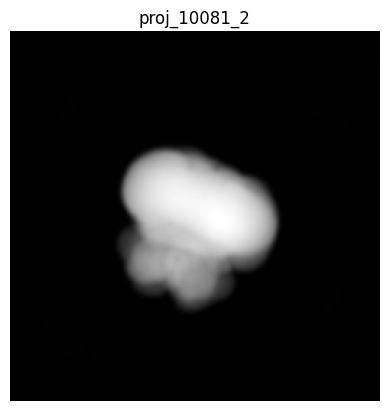

In [ ]:
# @title  { display-mode: "form" }
# @markdown Plot particle.

number_of_particle = particles.shape
idx = 2 # @param {type:"integer"}
image = particles[idx]
plt.imshow(image, 'gray')
plt.title(f"proj_{EMPIAR_ID}_{idx}")
plt.axis('off')
plt.show()

#### Test segmentation methods

In [ ]:
locations = labeled_particles[labeled_particles['image_name'] == name]

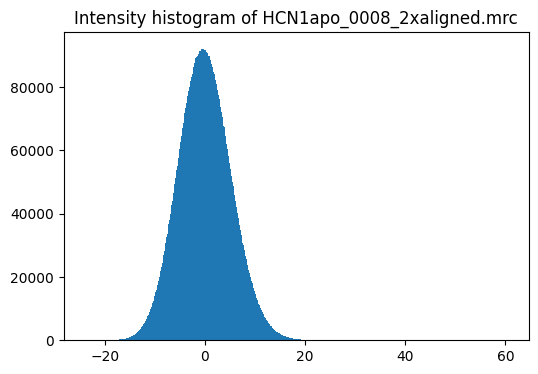

In [ ]:
# @markdown Micrograph intensity histogram.

plt.subplots(figsize=(6, 4))
plt.hist(micrograph.ravel(), bins=1000)
plt.title(f"Intensity histogram of {name+'.mrc'}")
plt.show()

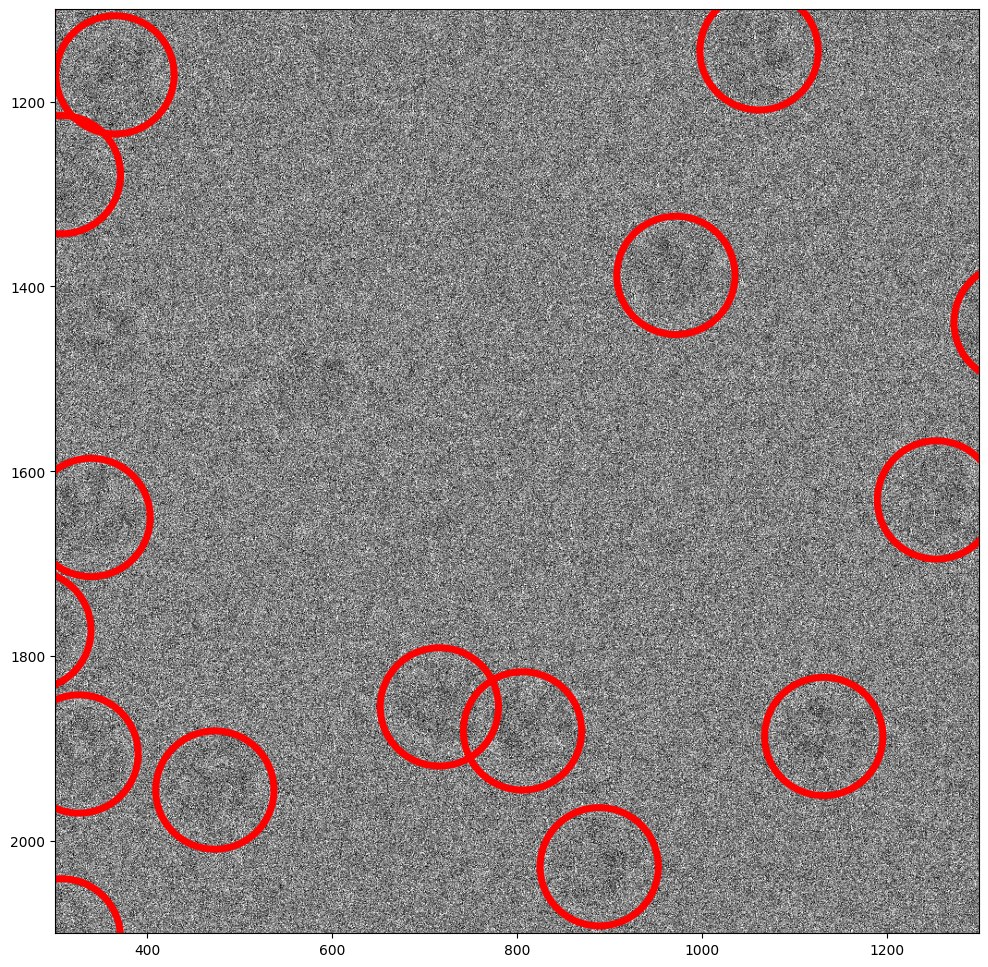

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches

# Assume `simple_micrograph_preprocessing` and `locations` are defined elsewhere
_, ax = plt.subplots(figsize=(12, 12))
micrograph_copy = simple_micrograph_preprocessing(micrograph)
ax.imshow(micrograph_copy, cmap='gray')

# Set the limits to zoom in
ax.set_xlim(300, 1300)
ax.set_ylim(2100, 1100)  # Note: the y-axis in images goes from top to bottom

# Adding the circle patches
#indx = locations.index[0]
#x, y = locations.loc[indx][['x_coord', 'y_coord']]
#c = matplotlib.patches.Circle((x, y), radius=64, fill=False, color='b')
#ax.add_patch(c)
for indx in locations.index[1:]:
    x, y = locations.loc[indx][['x_coord', 'y_coord']]
    c = matplotlib.patches.Circle((x, y), radius=64, fill=False, color='r', linewidth=5)
    ax.add_patch(c)

plt.show()

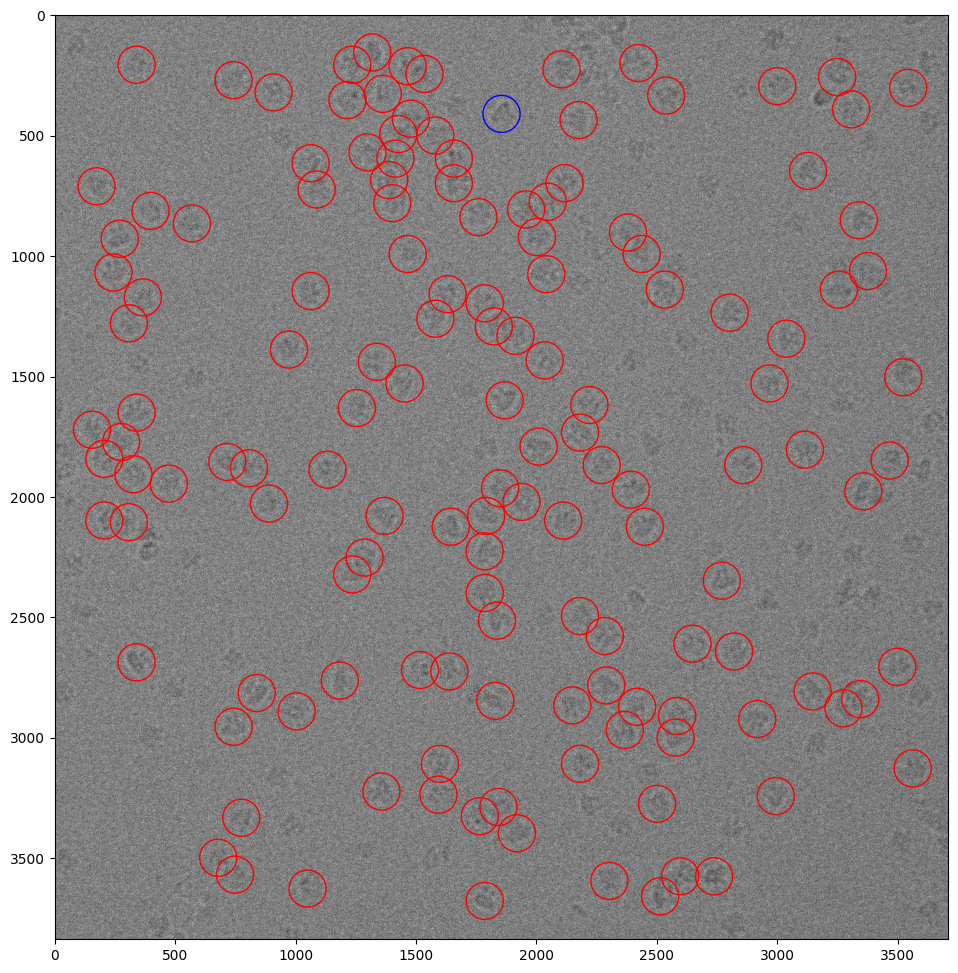

In [ ]:
# @markdown Particles view. { display-mode: "form" }

_, ax = plt.subplots(figsize=(12, 12))
micrograph_copy = simple_micrograph_preprocessing(micrograph)
ax.imshow(micrograph_copy, cmap='gray')

indx = locations.index[0]
x, y = locations.loc[indx][['x_coord', 'y_coord']]
c = matplotlib.patches.Circle((x, y), radius=77, fill=False, color='b')
ax.add_patch(c)
for indx in locations.index[1:]:
  x, y = locations.loc[indx][['x_coord', 'y_coord']]
  c = matplotlib.patches.Circle((x, y), radius=77, fill=False, color='r')
  ax.add_patch(c)
plt.show()

In [ ]:
df = starfile.read(f"{EMPIAR_DIR}/processed/refinement_result.star")
df_optics2, df_particles2 = df['optics'].copy(), df['particles'].copy()

In [ ]:
pd.DataFrame(df_particles2.loc[indx])

34447
rlnImageName     000149@J1/imported/015014368677227038714_HCN1a...
rlnAngleRot                                              69.647285
rlnAngleTilt                                             31.977957
rlnAnglePsi                                             120.805656
rlnOriginXAngst                                          10.638309
rlnOriginYAngst                                         -25.508438
rlnDefocusU                                           39338.671875
rlnDefocusV                                           37572.003906
rlnDefocusAngle                                         -75.486435
rlnPhaseShift                                                  0.0
rlnCtfBfactor                                                  0.0
rlnOpticsGroup                                                   2
rlnRandomSubset                                                  2
rlnClassNumber                                                   1

In [ ]:
locations.loc[indx]

image_name    HCN1apo_0008_2xaligned
x_coord                         1414
y_coord                          595
Name: 34447, dtype: object

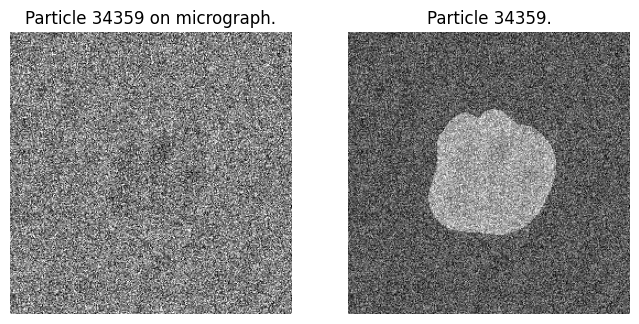

In [ ]:
# @title  { display-mode: "form" }
# @markdown Segmentation demonstration.

pixel_size = 1.3 # @param {type:"number"}
idx = 53 # @param {type:"integer"}
indx = locations.index[idx]
x, y = locations.loc[indx][['x_coord', 'y_coord']]
image = particles[indx].copy()
tform = transform.EuclideanTransform(
   rotation = 0,
   translation = (df_particles2.loc[indx]['rlnOriginXAngst']/pixel_size, df_particles2.loc[indx]['rlnOriginYAngst']/pixel_size)
   )
tf_img = transform.warp(image, tform.inverse)
image_seg = segment(tf_img)

# fig, axes = plt.subplots(1, 2, figsize=(16, 8))
fig, axes = plt.subplots(1, 2, figsize=(8, 4))
ax = axes.flatten()

ax[0].imshow(micrograph_copy[y-128:y+128,x-128:x+128], cmap="gray")
#ax[0].imshow(image_seg, cmap="gray", alpha=0.5)
ax[0].set_axis_off()
ax[0].set_title(f"Particle {indx} on micrograph.", fontsize=12)
c = matplotlib.patches.Circle((x, y), radius=64, fill=False, color='r')
ax[0].add_patch(c)

ax[1].imshow(micrograph_copy[y-128:y+128,x-128:x+128], cmap="gray")
#ax[1].imshow(tf_img, cmap="gray")
ax[1].imshow(image_seg, cmap="gray", alpha=0.3)
ax[1].set_axis_off()
ax[1].set_title(f"Particle {indx}.", fontsize=12)
plt.show()

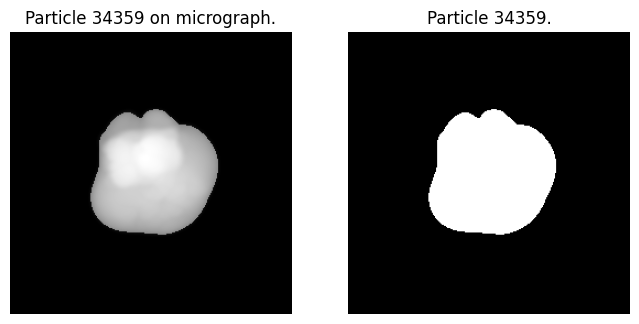

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(8, 4))
ax = axes.flatten()

ax[0].imshow(tf_img, cmap="gray")
ax[0].imshow(image_seg, cmap="gray", alpha=0.5)
ax[0].set_axis_off()
ax[0].set_title(f"Particle {indx} on micrograph.", fontsize=12)
c = matplotlib.patches.Circle((x, y), radius=77, fill=False, color='r')
ax[0].add_patch(c)

#ax[1].imshow(micrograph_copy[y-128:y+128,x-128:x+128], cmap="gray")
ax[1].imshow(image_seg, cmap="gray")
#ax[1].imshow(image_seg, cmap="gray", alpha=0.3)
ax[1].set_axis_off()
ax[1].set_title(f"Particle {indx}.", fontsize=12)
plt.show()

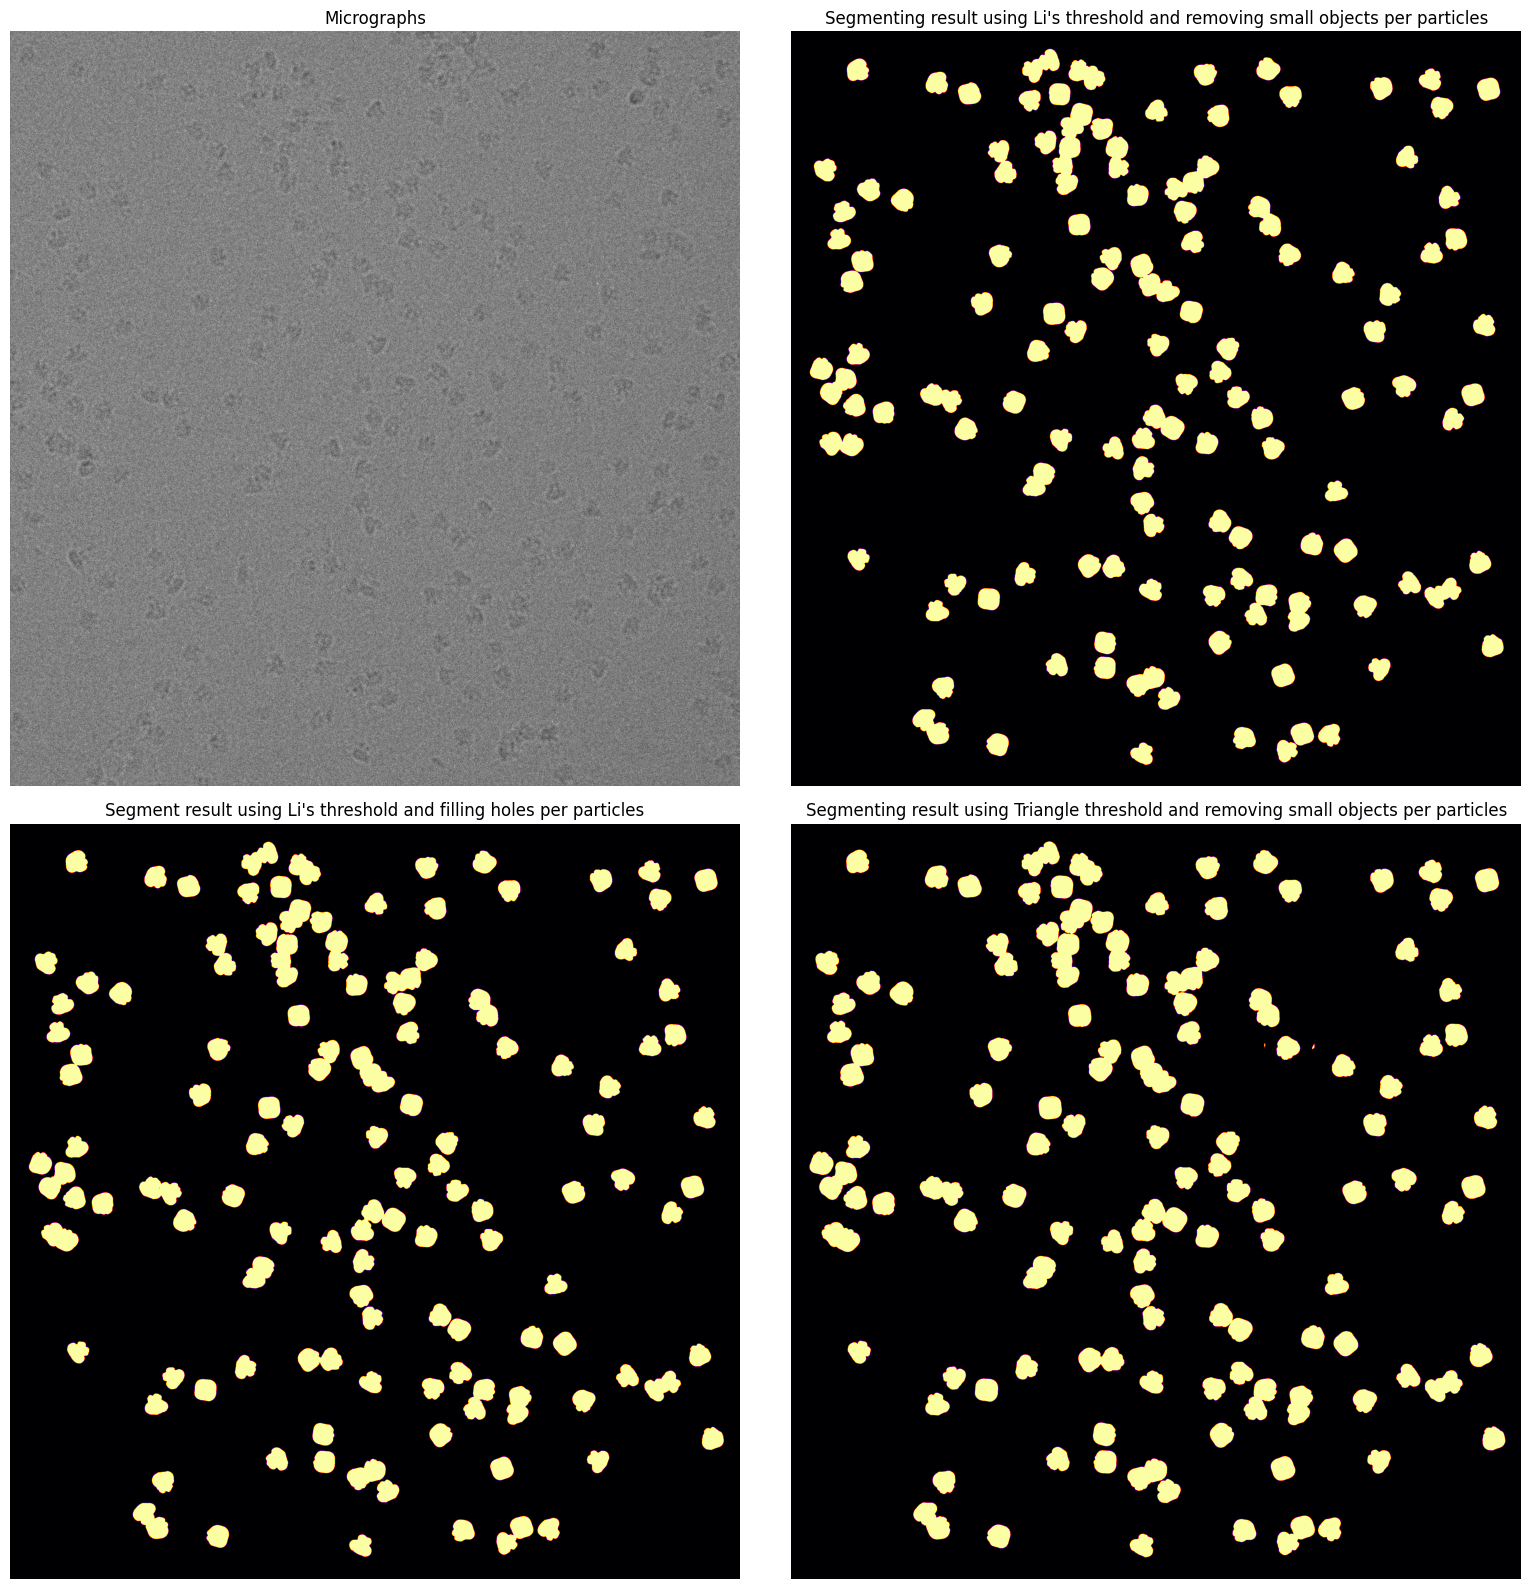

In [ ]:
# @title  { display-mode: "form" }
# @markdown Particles segment result.

diameter = 128 # @param {type:"integer"}
pixel_size = 1.3 # @param {type:"number"}
micrograph_copy = simple_micrograph_preprocessing(micrograph)
micrograph_segment = np.zeros_like(micrograph, dtype=bool) # .astype(bool)
micrograph_segment_fill = np.zeros_like(micrograph, dtype=bool)
micrograph_segment_triangle = np.zeros_like(micrograph, dtype=bool)

for indx in locations.index:
  x, y = locations.loc[indx][['x_coord', 'y_coord']]
  image = particles[indx].copy()
  tform = transform.EuclideanTransform(
    rotation = 0,
    translation = (df_particles2.loc[indx]['rlnOriginXAngst']/pixel_size, df_particles2.loc[indx]['rlnOriginYAngst']/pixel_size)
    )
  tf_img = transform.warp(image, tform.inverse)
  image_seg = segment(tf_img)
  micrograph_segment[y-diameter:y+diameter,x-diameter:x+diameter] += image_seg
  micrograph_segment_fill[y-diameter:y+diameter,x-diameter:x+diameter] += segment_fill(image)
  micrograph_segment_triangle[y-diameter:y+diameter,x-diameter:x+diameter] += segment_triangle(image)

fig, axes = plt.subplots(2, 2, figsize=(16, 16))
ax = axes.flatten()

ax[0].imshow(micrograph_copy, cmap='gray')
ax[0].set_axis_off()
ax[0].set_title("Micrographs", fontsize=12)

ax[1].imshow(micrograph_segment, cmap='inferno')
ax[1].set_axis_off()
ax[1].set_title("Segmenting result using Li's threshold and removing small objects per particles", fontsize=12)

ax[2].imshow(micrograph_segment_fill, cmap='inferno')
ax[2].set_axis_off()
ax[2].set_title("Segment result using Li's threshold and filling holes per particles", fontsize=12)

ax[3].imshow(micrograph_segment_triangle, cmap='inferno')
ax[3].set_axis_off()
ax[3].set_title("Segmenting result using Triangle threshold and removing small objects per particles", fontsize=12)

fig.tight_layout()
plt.show()

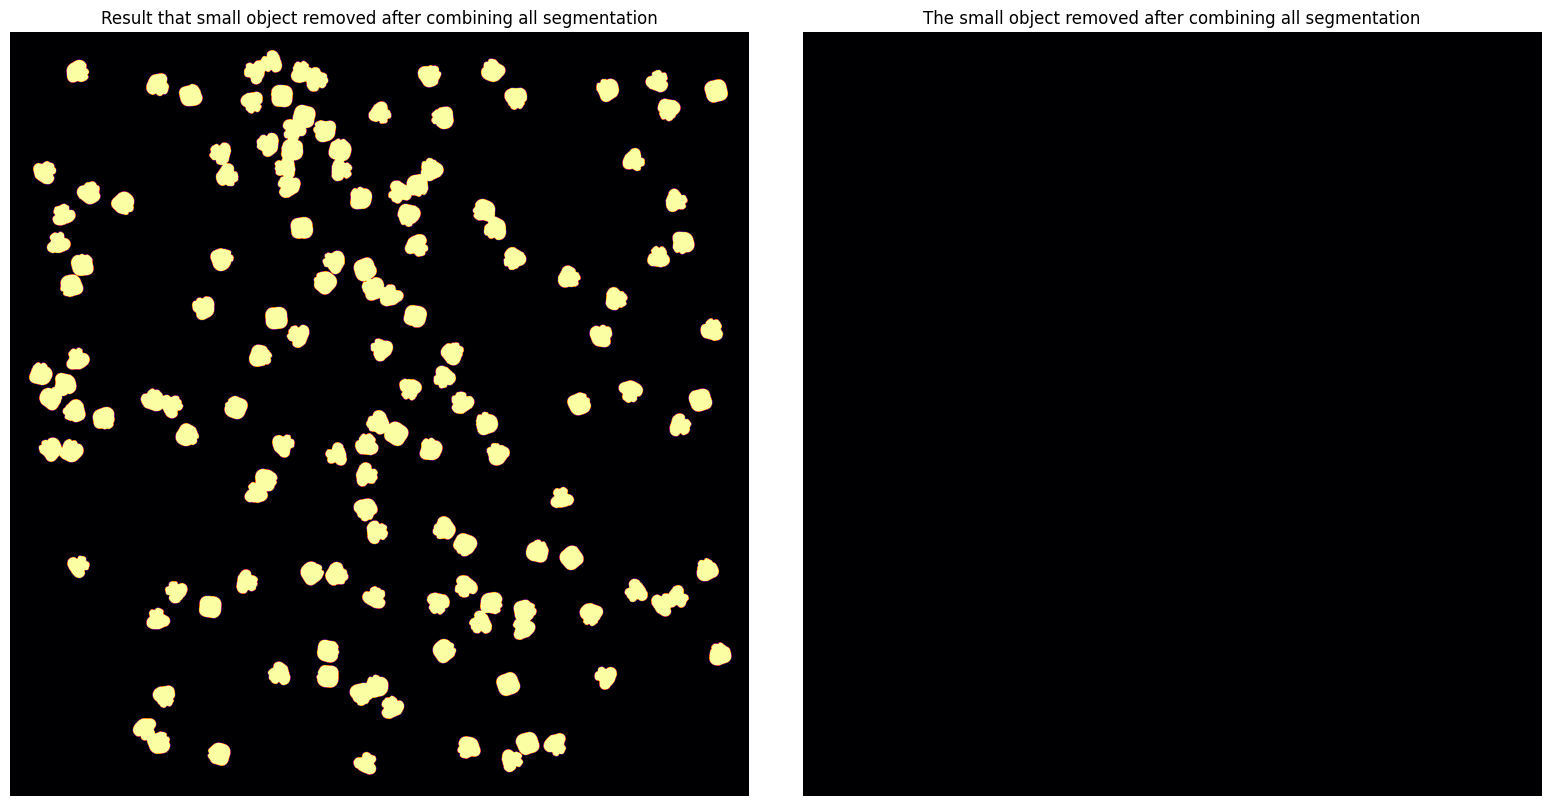

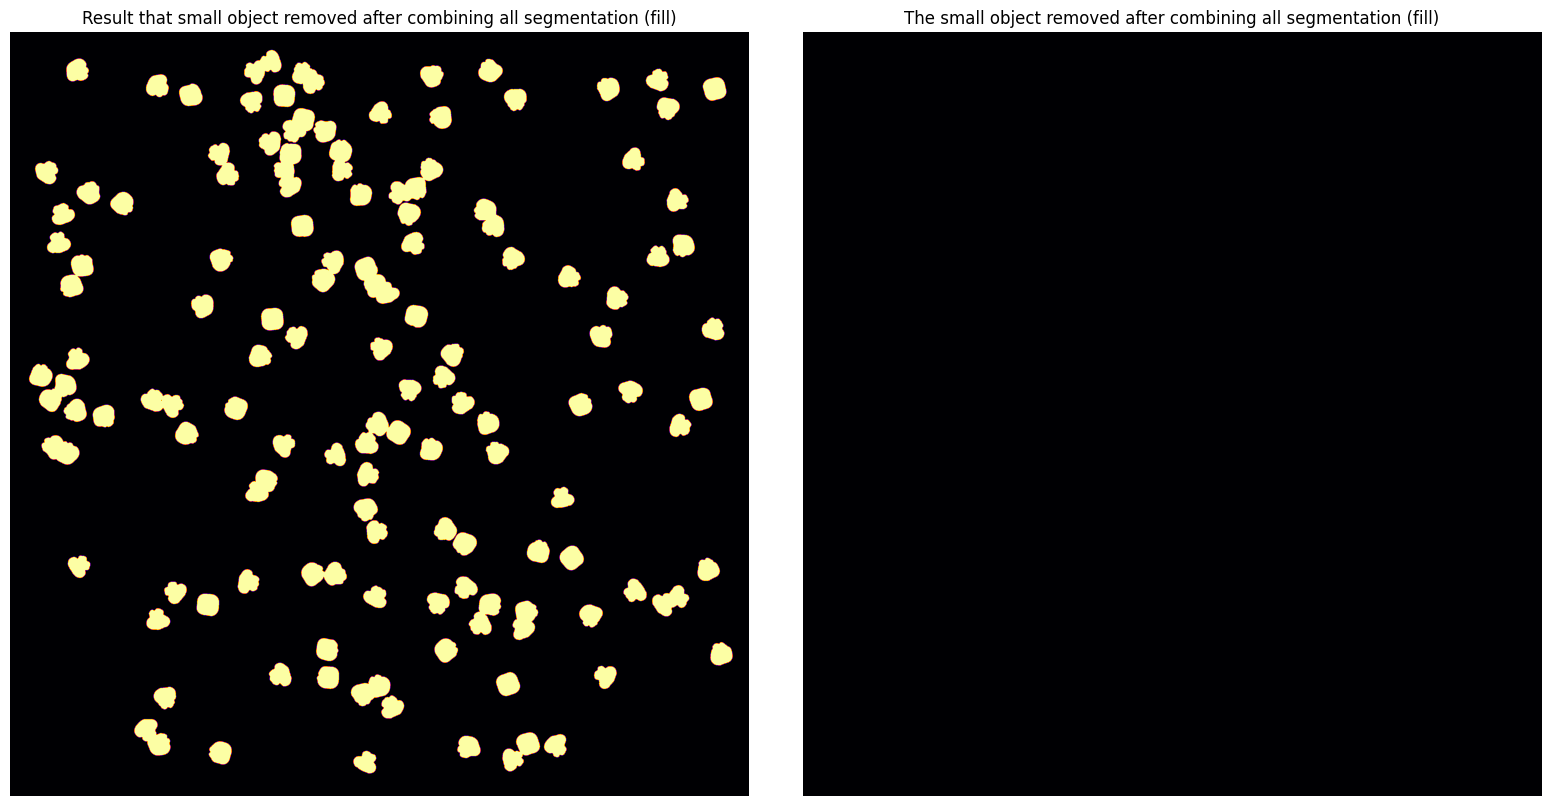

Segmentation created small objects: False
Segmentation (fill) created small objects: False


In [ ]:
# @title  { display-mode: "form" }
# @markdown Check whether small objects have been created.

micrograph_segment_clear = morphology.remove_small_objects(micrograph_segment, 2048)
micrograph_segment_removed = np.logical_xor(micrograph_segment, micrograph_segment_clear)

micrograph_segment_fill_clear = morphology.remove_small_objects(micrograph_segment_fill, 2048)
micrograph_segment_fill_removed = np.logical_xor(micrograph_segment_fill, micrograph_segment_fill_clear)

fig, axes = plt.subplots(1, 2, figsize=(16, 8))
ax = axes.flatten()

ax[0].imshow(micrograph_segment_clear, cmap='inferno')
ax[0].set_axis_off()
ax[0].set_title("Result that small object removed after combining all segmentation", fontsize=12)

ax[1].imshow(micrograph_segment_removed, cmap='inferno')
ax[1].set_axis_off()
ax[1].set_title("The small object removed after combining all segmentation", fontsize=12)

fig.tight_layout()
plt.show()

fig, axes = plt.subplots(1, 2, figsize=(16, 8))
ax = axes.flatten()

ax[0].imshow(micrograph_segment_fill_clear, cmap='inferno')
ax[0].set_axis_off()
ax[0].set_title("Result that small object removed after combining all segmentation (fill)", fontsize=12)

ax[1].imshow(micrograph_segment_fill_removed, cmap='inferno')
ax[1].set_axis_off()
ax[1].set_title("The small object removed after combining all segmentation (fill)", fontsize=12)

fig.tight_layout()
plt.show()

print("Segmentation created small objects:", micrograph_segment_removed.any())
print("Segmentation (fill) created small objects:", micrograph_segment_fill_removed.any())

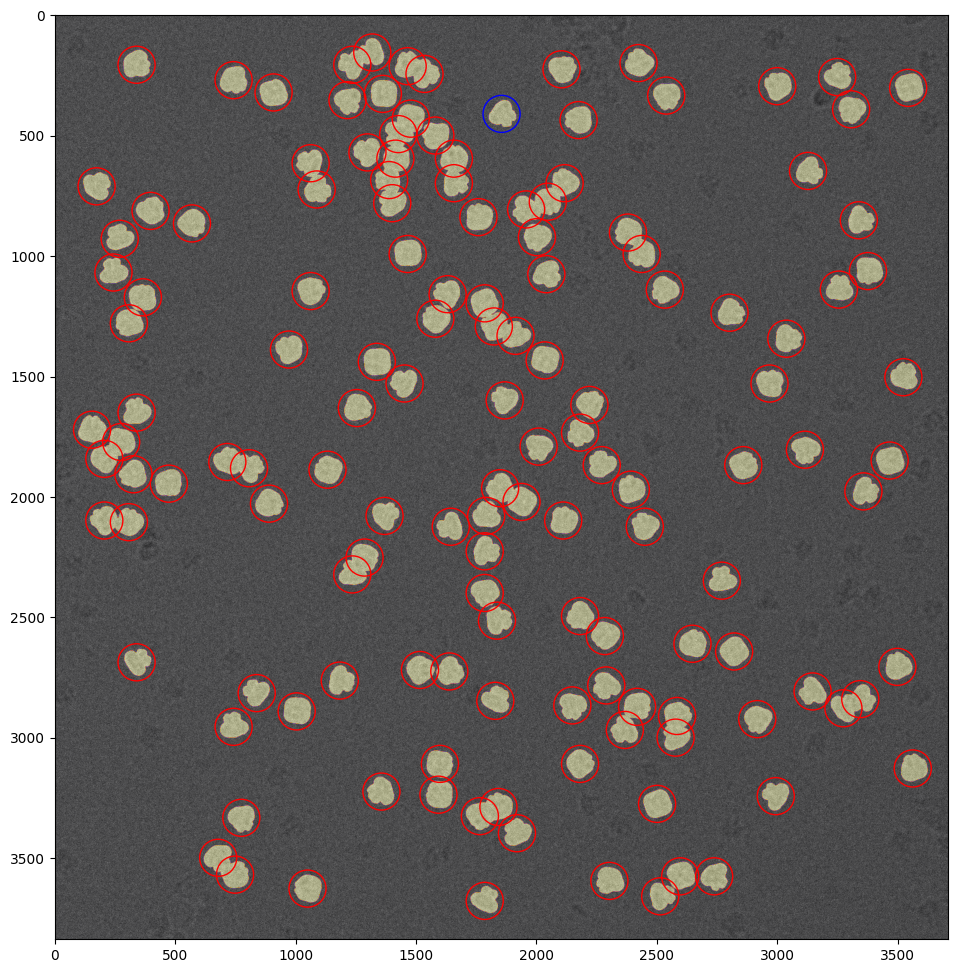

In [ ]:
# @markdown Particles

_,ax = plt.subplots(figsize=(12, 12))

ax.imshow(micrograph_copy, cmap='gray')
ax.imshow(micrograph_segment, cmap='inferno', alpha=0.4)

indx = locations.index[0]
x, y = locations.loc[indx][['x_coord', 'y_coord']]
c = matplotlib.patches.Circle((x, y), radius=77, fill=False, color='b')
ax.add_patch(c)
for indx in locations.index[1:]:
  x, y = locations.loc[indx][['x_coord', 'y_coord']]
  c = matplotlib.patches.Circle((x, y), radius=77, fill=False, color='r')
  ax.add_patch(c)
plt.show()

Just using minimum cross entropy thresholding is enough.

In [ ]:
if not os.path.exists(MICROGRAPH_DIR):
  !mkdir {RESULT_DIR}/{MICROGRAPH_DIR}

### ✅ Segmenting all micrograph

In [ ]:
# @markdown Set directory.
# @markdown If any of the following directory is not given, the image will not be saved.
MICROGRAPH_DIR = "micrographs_np" # @param {type:"string"}
PROCESSED_MICROGRAPH_DIR = "processed_micrographs_np" # @param {type:"string"}
GROUND_TRUTH_DIR = "micrographs_ground_np" # @param {type:"string"}

if MICROGRAPH_DIR:
  os.mkdir(f"{RESULT_DIR}/dataset/{EMPIAR_ID}/{MICROGRAPH_DIR}")
if PROCESSED_MICROGRAPH_DIR:
  os.mkdir(f"{RESULT_DIR}/dataset/{EMPIAR_ID}/{PROCESSED_MICROGRAPH_DIR}")
if GROUND_TRUTH_DIR:
  os.mkdir(f"{RESULT_DIR}/dataset/{EMPIAR_ID}/{GROUND_TRUTH_DIR}")

In [ ]:
labeled_particles

image_name  x_coord  y_coord
0      HCN1apo_0183_2xaligned     2041     3454
1      HCN1apo_0183_2xaligned      985     1017
2      HCN1apo_0183_2xaligned     2258     1772
3      HCN1apo_0183_2xaligned     1529     3218
4      HCN1apo_0183_2xaligned     3416     3582
...                       ...      ...      ...
39347  HCN1apo_0686_2xaligned     1861     3704
39348  HCN1apo_0686_2xaligned      966     1126
39349  HCN1apo_0686_2xaligned     2316      991
39350  HCN1apo_0686_2xaligned     2047     2156
39351  HCN1apo_0686_2xaligned      908      390

[39352 rows x 3 columns]

In [ ]:
%%capture --no-display
# @markdown Run segmentation for all micrographs.

pixel_size = 1.3 # @param {type:"number"}
diameter = 128 # @param {type:"integer"}
plot = True # @param {type:"boolean"}
plot_processed = True # @param {type:"boolean"}

if not os.path.exists(MICROGRAPH_DIR):
  !mkdir {RESULT_DIR}/dataset/{EMPIAR_ID}/{MICROGRAPH_DIR}

if not os.path.exists(PROCESSED_MICROGRAPH_DIR):
  !mkdir {RESULT_DIR}/dataset/{EMPIAR_ID}/{PROCESSED_MICROGRAPH_DIR}

if not os.path.exists(GROUND_TRUTH_DIR):
  !mkdir {RESULT_DIR}/dataset/{EMPIAR_ID}/{GROUND_TRUTH_DIR}

for name in image_names:
  with mrcfile.open(f"{EMPIAR_DIR}/micrographs/{name}.mrc") as mrcs:
    micrograph = mrcs.data
  locations = labeled_particles[labeled_particles['image_name'] == name]
  micrograph_segment = np.zeros_like(micrograph, dtype=bool)

  for indx in locations.index:
    x, y = locations.loc[indx][['x_coord', 'y_coord']]
    image = particles[indx].copy()
    tform = transform.EuclideanTransform(
        rotation = 0,
        translation = (df_particles2.loc[indx]['rlnOriginXAngst']/pixel_size, df_particles2.loc[indx]['rlnOriginYAngst']/pixel_size)
        )
    tf_img = transform.warp(image, tform.inverse)
    image_seg = segment(tf_img)
    micrograph_segment[y-diameter:y+diameter,x-diameter:x+diameter] += image_seg

  if MICROGRAPH_DIR:
    img = Image.fromarray(np.uint8(255 * micrograph))  # no opencv required
    img.save(f"{RESULT_DIR}/dataset/{EMPIAR_ID}/{MICROGRAPH_DIR}/{name}.png")

  if PROCESSED_MICROGRAPH_DIR:
    with mrcfile.open(f"{PROCESSED_DIR}/micrographs/{name}.mrc", permissive=True) as mrcs:
      processed_micrograph = mrcs.data
    img = Image.fromarray(np.uint8(255 * processed_micrograph))  # no opencv required
    img.save(f"{RESULT_DIR}/dataset/{EMPIAR_ID}/{PROCESSED_MICROGRAPH_DIR}/{name}.png")

  if GROUND_TRUTH_DIR:
    img = Image.fromarray(np.uint8(255 * micrograph_segment))  # no opencv required
    img.save(f"{RESULT_DIR}/dataset/{EMPIAR_ID}/{GROUND_TRUTH_DIR}/{name}.png")

  if plot:
    _, ax = plt.subplots(figsize=(12, 12))

    if plot_processed:
      ax.imshow(simple_micrograph_preprocessing(processed_micrograph), cmap='gray')
    else:
      ax.imshow(simple_micrograph_preprocessing(micrograph), cmap='gray')
    ax.imshow(micrograph_segment, cmap='inferno', alpha=0.4)

    for indx in locations.index:
      x, y = locations.loc[indx][['x_coord', 'y_coord']]
      c = matplotlib.patches.Circle((x, y), radius=77, fill=False, color='r')
      ax.add_patch(c)

    plt.show()

In [ ]:
RESULT_DIR

# Run CryoSparc

In [ ]:
from pyngrok import ngrok, conf
import getpass

In [ ]:
print("Enter your authtoken, which can be copied from https://dashboard.ngrok.com/")
conf.get_default().auth_token = getpass.getpass()

Enter your authtoken, which can be copied from https://dashboard.ngrok.com/auth
··········


In [ ]:
# Setup a tunnel to the port 61000
public_url = ngrok.connect(61000)

In [ ]:
public_url

<NgrokTunnel: "https://46dd-35-229-173-203.ngrok-free.app" -> "http://localhost:61000">